In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import PIL
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Rescaling, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory, set_random_seed
set_random_seed(42)

In [2]:
# downloading the data
data_dir = tf.keras.utils.get_file(
    fname='flower_photos',
    origin="http://download.tensorflow.org/example_images/flower_photos.tgz",
    untar=True)

In [3]:
# preparing the data
train_ds, val_ds = image_dataset_from_directory(
    directory=data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    subset='both',
    validation_split=.25,
    seed=42)

Found 3670 files belonging to 5 classes.
Using 2753 files for training.
Using 917 files for validation.


In [4]:
# printing class names in dataset
print(train_ds.class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [5]:
# getting the mobilenet
Mobilenet = MobileNet(weights="imagenet", include_top=False, pooling='max', input_shape=(224, 224, 3))

In [6]:
# finding layers to retrain
for i, layer in enumerate(Mobilenet.layers):
   print(i,':', '<', layer.name, '>', layer.trainable)

0 : < input_1 > True
1 : < conv1 > True
2 : < conv1_bn > True
3 : < conv1_relu > True
4 : < conv_dw_1 > True
5 : < conv_dw_1_bn > True
6 : < conv_dw_1_relu > True
7 : < conv_pw_1 > True
8 : < conv_pw_1_bn > True
9 : < conv_pw_1_relu > True
10 : < conv_pad_2 > True
11 : < conv_dw_2 > True
12 : < conv_dw_2_bn > True
13 : < conv_dw_2_relu > True
14 : < conv_pw_2 > True
15 : < conv_pw_2_bn > True
16 : < conv_pw_2_relu > True
17 : < conv_dw_3 > True
18 : < conv_dw_3_bn > True
19 : < conv_dw_3_relu > True
20 : < conv_pw_3 > True
21 : < conv_pw_3_bn > True
22 : < conv_pw_3_relu > True
23 : < conv_pad_4 > True
24 : < conv_dw_4 > True
25 : < conv_dw_4_bn > True
26 : < conv_dw_4_relu > True
27 : < conv_pw_4 > True
28 : < conv_pw_4_bn > True
29 : < conv_pw_4_relu > True
30 : < conv_dw_5 > True
31 : < conv_dw_5_bn > True
32 : < conv_dw_5_relu > True
33 : < conv_pw_5 > True
34 : < conv_pw_5_bn > True
35 : < conv_pw_5_relu > True
36 : < conv_pad_6 > True
37 : < conv_dw_6 > True
38 : < conv_dw_6_bn >

In [7]:
# deciding what layers to retrain
for layer in Mobilenet.layers[:80]:
   layer.trainable = False
for layer in Mobilenet.layers[80:]:
   layer.trainable = True

In [8]:
# checking the applied changes
for i, layer in enumerate(Mobilenet.layers):
  print(i, ':', '<', layer.name, '>', layer.trainable)

0 : < input_1 > False
1 : < conv1 > False
2 : < conv1_bn > False
3 : < conv1_relu > False
4 : < conv_dw_1 > False
5 : < conv_dw_1_bn > False
6 : < conv_dw_1_relu > False
7 : < conv_pw_1 > False
8 : < conv_pw_1_bn > False
9 : < conv_pw_1_relu > False
10 : < conv_pad_2 > False
11 : < conv_dw_2 > False
12 : < conv_dw_2_bn > False
13 : < conv_dw_2_relu > False
14 : < conv_pw_2 > False
15 : < conv_pw_2_bn > False
16 : < conv_pw_2_relu > False
17 : < conv_dw_3 > False
18 : < conv_dw_3_bn > False
19 : < conv_dw_3_relu > False
20 : < conv_pw_3 > False
21 : < conv_pw_3_bn > False
22 : < conv_pw_3_relu > False
23 : < conv_pad_4 > False
24 : < conv_dw_4 > False
25 : < conv_dw_4_bn > False
26 : < conv_dw_4_relu > False
27 : < conv_pw_4 > False
28 : < conv_pw_4_bn > False
29 : < conv_pw_4_relu > False
30 : < conv_dw_5 > False
31 : < conv_dw_5_bn > False
32 : < conv_dw_5_relu > False
33 : < conv_pw_5 > False
34 : < conv_pw_5_bn > False
35 : < conv_pw_5_relu > False
36 : < conv_pad_6 > False
37 : < c

In [9]:
# getting a summary of the mobilenet configuration
Mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [10]:
# model architecture using Sequential API
model = Sequential([
    Rescaling(scale=1.0/ 224.0, input_shape=(224, 224, 3)),
    Mobilenet,
    Flatten(),
    Dense(40, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(rate=.1),
    Dense(20, activation='relu', kernel_initializer='he_normal'),
    Dense(5, activation='softmax')
])

### with Functional API
x = Mobilenet.output

x = Flatten()(x)

x = Dense(40, activation='relu')(x)

x = BatchNormalization()(x)

x = Dropout(rate=.15)(x)

x = Dense(20, activation='relu')(x)

output = Dense(5, activation='softmax')(x)

model = Model(inputs=Mobilenet.input, outputs=output)

In [11]:
# getting a complete summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 40)                41000     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0

In [12]:
# model compilation
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# model training
history = model.fit(train_ds, epochs=10, batch_size=32, validation_data=val_ds, verbose=1)

Epoch 1/10
87/87 [==============================] - 22s 138ms/step - loss: 0.7194 - accuracy: 0.7693 - val_loss: 0.8377 - val_accuracy: 0.7579
Epoch 2/10
87/87 [==============================] - 7s 78ms/step - loss: 0.2270 - accuracy: 0.9364 - val_loss: 0.4443 - val_accuracy: 0.8364
Epoch 3/10
87/87 [==============================] - 8s 78ms/step - loss: 0.0808 - accuracy: 0.9847 - val_loss: 0.4567 - val_accuracy: 0.8506
Epoch 4/10
87/87 [==============================] - 8s 90ms/step - loss: 0.0307 - accuracy: 0.9978 - val_loss: 0.3315 - val_accuracy: 0.8942
Epoch 5/10
87/87 [==============================] - 8s 89ms/step - loss: 0.0186 - accuracy: 0.9982 - val_loss: 0.3474 - val_accuracy: 0.8920
Epoch 6/10
87/87 [==============================] - 7s 77ms/step - loss: 0.0141 - accuracy: 0.9985 - val_loss: 0.3054 - val_accuracy: 0.9029
Epoch 7/10
87/87 [==============================] - 8s 80ms/step - loss: 0.0084 - accuracy: 0.9989 - val_loss: 0.3613 - val_accuracy: 0.8920
Epoch 8/10


In [14]:
# model evaluation
score = model.evaluate(val_ds, verbose=0)
print('Accuracy:', round(score[1] * 100, 2))

Accuracy: 90.08


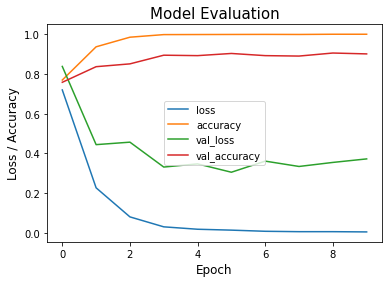

In [15]:
# plotting model performance
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss / Accuracy', size=12)
plt.title('Model Evaluation', size=15);

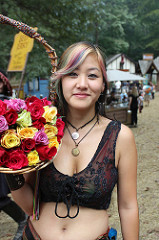

In [16]:
# fetching an actual image making predictions
data_dir = pathlib.Path(data_dir)
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [17]:
# making predictions
image = cv2.imread(str(roses[0]))
image_resized = cv2.resize(image, (224, 224))
image = np.expand_dims(image_resized, axis=0)
pred = model.predict(image, verbose=0)
output = train_ds.class_names[np.argmax(pred)]
print('The predicted image belongs to the class:', str(output).capitalize())

The predicted image belongs to the class: Roses
